In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.inspection import permutation_importance
from spark.preprocessor import questionair_preprocessor
from spark.model_io import load_model
from spark.train import train_base_model, evaluate_base_model
import joblib


In [2]:
label_mapping = {0: "Healthy", 1: "Parkinson's", 2: "Other Movement Disorder"}

In [3]:
input_csv = '../merged_df.csv'

In [4]:
X_train_prep, X_test_prep, y_train_prep, y_test_prep = questionair_preprocessor(input_csv=input_csv)

✅ Transformer saved at: ./model_registry/transformer_20250908-154506.joblib


In [5]:
X_test_prep.shape

(94, 38)

In [6]:
X_train_prep.shape

(375, 38)

In [7]:
y_train_prep.shape

(375,)

In [8]:
X_train_prep

array([[-0.41176471, -0.23529412,  0.91666667, ...,  1.        ,
         1.        ,  0.        ],
       [-0.29411765, -0.47058824, -0.33333333, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.52941176,  0.11764706,  0.5       , ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [ 0.94117647,  0.52941176, -0.08333333, ...,  1.        ,
         1.        ,  0.        ],
       [-0.05882353, -0.47058824, -0.66666667, ...,  0.        ,
         1.        ,  0.        ],
       [-0.47058824, -0.76470588, -0.91666667, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
#X_train_dense = X_train_prep.toarray()
#print(X_train_dense)
#X_test_dense = X_test_prep.toarray()

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [16]:
#model_path = '/Users/yulingsun/code/marzecovaa/spark/notebooks/model_registry/model_20250904-222835.joblib'
model_path = train_base_model(
    X_train=X_train_prep,
    y_train=y_train_prep,
    random_state=42,
    max_iter=1000,
    n_splits=5,
    verbose=0)
question_model = load_model(model_path)

Saved locally: ./model_registry/model_20250908-155122.joblib
Loading model from: ./model_registry/model_20250908-155122.joblib


In [17]:
question_model.get_params()

{'cv': StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
 'estimators': [('svc',
   SVC(class_weight='balanced', probability=True, random_state=42)),
  ('catboost', <catboost.core.CatBoostClassifier at 0x1391af190>)],
 'final_estimator__C': 1.0,
 'final_estimator__class_weight': 'balanced',
 'final_estimator__dual': False,
 'final_estimator__fit_intercept': True,
 'final_estimator__intercept_scaling': 1,
 'final_estimator__l1_ratio': None,
 'final_estimator__max_iter': 1000,
 'final_estimator__multi_class': 'deprecated',
 'final_estimator__n_jobs': None,
 'final_estimator__penalty': 'l2',
 'final_estimator__random_state': 42,
 'final_estimator__solver': 'lbfgs',
 'final_estimator__tol': 0.0001,
 'final_estimator__verbose': 0,
 'final_estimator__warm_start': False,
 'final_estimator': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 'n_jobs': -1,
 'passthrough': True,
 'stack_method': 'auto',
 'verbose': 0,
 'svc': SVC(class_weight='balanced', prob

In [18]:
permutation_score = permutation_importance(question_model, X_test_prep, y_test_prep, n_repeats=10)


In [19]:
transformer = joblib.load('/Users/yulingsun/code/marzecovaa/spark/notebooks/model_registry/transformer_20250908-154506.joblib')

In [20]:
feature_names = transformer.get_feature_names_out()
importance_df = pd.DataFrame({
    'feature_name': feature_names,
    'score_decrease': permutation_score.importances_mean,
    'std': permutation_score.importances_std
})

importance_df = importance_df.sort_values(by="score_decrease", ascending=False)
print(importance_df.head(15))

                       feature_name  score_decrease       std
0          robust__age_at_diagnosis        0.130851  0.019060
6                      enc__02_True        0.074468  0.025175
1                       robust__age        0.055319  0.022717
7                      enc__03_True        0.038298  0.021383
17                     enc__13_True        0.035106  0.008309
13                     enc__09_True        0.031915  0.033976
24                     enc__20_True        0.030851  0.030997
35                 enc__gender_male        0.029787  0.017021
29                     enc__25_True        0.028723  0.019060
21                     enc__17_True        0.027660  0.012766
37  enc__appearance_in_kinship_True        0.023404  0.014113
5                      enc__01_True        0.022340  0.017448
8                      enc__04_True        0.011702  0.016099
31                     enc__27_True        0.010638  0.014273
27                     enc__23_True        0.008511  0.012406


In [21]:
def simple_elbow_method(importance_df, X_train_prep, y_train_prep, max_features=40):
    """
    Simple elbow method to find optimal number of features
    """
    
    # Test different numbers of features (every 2 features to save time)
    feature_counts = list(range(2, min(max_features, len(importance_df)) + 1, 2))
    cv_scores = []
    
    
    
    print("Testing different numbers of features...")
    print("-" * 50)
    
    for n_features in feature_counts:
        # Get top N feature indices (importance_df is already sorted)
        top_features_df = importance_df.head(n_features)
        
        # Get the indices - we need to find where these features are in the original data
        # Since we have feature names, we need to map them back to indices
        feature_names_list = list(feature_names)  # Convert to list for indexing
        top_feature_indices = [feature_names_list.index(name) for name in top_features_df['feature_name']]
        
        # Select features from preprocessed data
        X_subset = X_train_prep[:, top_feature_indices]
        X_subset = X_subset.toarray() if hasattr(X_subset, 'toarray') else X_subset
        
        # Cross-validate
        scores = cross_val_score(question_model, X_subset, y_train_prep, cv=5)
        mean_score = scores.mean()
        cv_scores.append(mean_score)
        
        print(f"{n_features:2d} features: {mean_score:.4f} ± {scores.std():.4f}")
    
    # Create the elbow plot
    plt.figure(figsize=(10, 6))
    plt.plot(feature_counts, cv_scores, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of Top Features', fontsize=12)
    plt.ylabel('Cross-Validation Accuracy', fontsize=12)
    plt.title('Elbow Method for Feature Selection', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Find the elbow point using the "knee" detection
    # Calculate the rate of improvement (first derivative)
    improvements = np.diff(cv_scores)
    
    # Find where improvement becomes minimal
    # Elbow is where the improvement drops below a threshold
    avg_improvement = np.mean(improvements)
    improvement_threshold = avg_improvement * 0.2  # 20% of average improvement
    
    elbow_idx = None
    for i, improvement in enumerate(improvements):
        if improvement < improvement_threshold:
            elbow_idx = i
            break
    
    if elbow_idx is not None:
        elbow_features = feature_counts[elbow_idx + 1]  # +1 because diff shifts indices
        elbow_score = cv_scores[elbow_idx + 1]
        
        # Mark the elbow point on the plot
        plt.axvline(x=elbow_features, color='red', linestyle='--', alpha=0.7)
        plt.plot(elbow_features, elbow_score, 'ro', markersize=12, markerfacecolor='none', markeredgewidth=3)
        plt.annotate(f'Elbow Point\n{elbow_features} features\nScore: {elbow_score:.4f}', 
                    xy=(elbow_features, elbow_score),
                    xytext=(elbow_features + 3, elbow_score - 0.005),
                    arrowprops=dict(arrowstyle='->', color='red'),
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # Also mark the highest score
    best_idx = np.argmax(cv_scores)
    best_features = feature_counts[best_idx]
    best_score = cv_scores[best_idx]
    
    plt.plot(best_features, best_score, 'go', markersize=10, markerfacecolor='lightgreen')
    plt.annotate(f'Best Score\n{best_features} features', 
                xy=(best_features, best_score),
                xytext=(best_features - 5, best_score + 0.005),
                arrowprops=dict(arrowstyle='->', color='green'),
                fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print recommendations
    print("\n" + "="*60)
    print("RECOMMENDATIONS:")
    print("="*60)
    if elbow_idx is not None:
        print(f"🔍 Elbow Method suggests: {elbow_features} features (good balance)")
    print(f"🎯 Highest accuracy: {best_features} features (may overfit)")
    
    if elbow_idx is not None:
        print(f"\n💡 Recommended approach:")
        print(f"   - Start with {elbow_features} features for interpretability")
        print(f"   - Test with {best_features} features if you need max performance")
        return elbow_features, best_features
    else:
        print(f"\n💡 No clear elbow found. Recommended: {best_features} features")
        return best_features, best_features

# Run the elbow method


Testing different numbers of features...
--------------------------------------------------
 2 features: 0.4987 ± 0.0427
 4 features: 0.6187 ± 0.0451
 6 features: 0.6453 ± 0.0160
 8 features: 0.6640 ± 0.0417
10 features: 0.6747 ± 0.0418
12 features: 0.6587 ± 0.0392
14 features: 0.6560 ± 0.0259
16 features: 0.6533 ± 0.0304
18 features: 0.6533 ± 0.0146
20 features: 0.6480 ± 0.0287
22 features: 0.6453 ± 0.0401
24 features: 0.6587 ± 0.0383
26 features: 0.6453 ± 0.0364
28 features: 0.6507 ± 0.0516
30 features: 0.6533 ± 0.0413
32 features: 0.6400 ± 0.0422
34 features: 0.6507 ± 0.0441
36 features: 0.6427 ± 0.0399
38 features: 0.6560 ± 0.0473


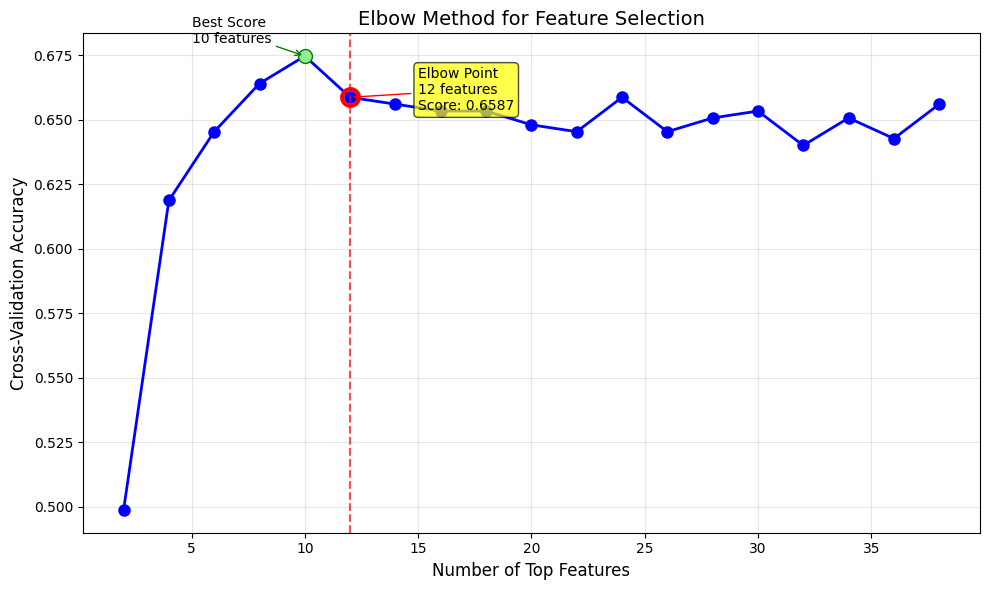


RECOMMENDATIONS:
🔍 Elbow Method suggests: 12 features (good balance)
🎯 Highest accuracy: 10 features (may overfit)

💡 Recommended approach:
   - Start with 12 features for interpretability
   - Test with 10 features if you need max performance


In [22]:
elbow_features, best_features = simple_elbow_method(
    importance_df, X_train_prep, y_train_prep, max_features=40
)

In [23]:
top_features_df = importance_df.head(10)
feature_names_list = list(feature_names)  
top_feature_indices = [feature_names_list.index(name) for name in top_features_df['feature_name']]
X_train_subset = X_train_prep[:, top_feature_indices]
X_test_subset = X_test_prep[:, top_feature_indices]



In [24]:
question_model.fit(X_train_subset, y_train_prep)

,estimators,"[('svc', ...), ('catboost', ...)]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,StratifiedKFo... shuffle=True)
,stack_method,'auto'
,n_jobs,-1
,passthrough,True
,verbose,0
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [25]:
y_test_prediction = question_model.predict(X_test_subset)

balanced_accuracy = balanced_accuracy_score(y_test_prep, y_test_prediction)

balanced_accuracy

0.7135046113306983

original prediction 

In [26]:
question_model.fit(X_train_prep, y_train_prep)

y_test_prediction_origin = question_model.predict(X_test_prep)

balanced_accuracy = balanced_accuracy_score(y_test_prep, y_test_prediction_origin)

balanced_accuracy

0.7259057971014493